<B><H2> HOUSE PRICE ESTIMATOR </H2></B><H5>TENSORFLOW REGRESSION SEQUENTIAL DNN MODEL</H5>


In [1]:
import docker
import requests
import json
import numpy as np
import pandas as pd



#TENSORFLOW API
import tensorflow as tf
import tensorflow_data_validation as tfdv
# Feature Engineering
from tensorflow import feature_column as fc
from keras.models import Sequential
from keras import layers
from keras import utils
# TF Dataset for input pipeline
import tensorflow_datasets as tfds

# VISUALISATION API
import matplotlib.pyplot as plt
import seaborn as sns # Seaborn is a Python data visualization library based on matplotlib.

# Import train_test_split function from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Used to calculate stats such as Z score, standard deviation etc.
from scipy import stats


2022-07-31 10:57:12.303096: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-07-31 10:57:12.435026: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-31 10:57:12.435275: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


<H5> READ THE DATA INTO PANDAS DATAFRAME.</H5> Remove any NULL values

In [2]:
city = 'Melbourne'

In [4]:
# Import data from CSV into pandas DF
df= pd.read_csv(f"data/{city}/{city}_area.csv")
# Check if there any NULL or NaN values
df.isnull().sum()
# Drop any NA values
df = df.dropna(how='any',axis=0)
# Check that there is no longer Null values
df.isnull().sum()
# Look at DF to get a feel of data
df.head()


,Street,Address,Suburb,State,Postcode,Type,Date,Method,Price,Bedrooms,Bathrooms,Cars,Area,Agent,Latitude,Longitude,Distance
0,413/250 Barkly Street,FOOTSCRAY VIC 3011,FOOTSCRAY,VIC,3011,House,22-Jul-22,private treaty,455,2,1,1,0.0,Sweeney Estate Agents Yarraville,-37.798134,144.897345,6.054337
1,28 Moubray Street,ALBERT PARK VIC 3206,ALBERT PARK,VIC,3206,House,27-Nov-21,auction,2270000,2,1,1,0.0,Marshall White Port Phillip,-37.840971,144.951109,3.158503
2,17 Paul Street,CHELTENHAM VIC 3192,CHELTENHAM,VIC,3192,House,26-Nov-21,auction,2260000,4,2,2,0.0,Buxton Real Estate Mentone,-37.961458,145.047628,17.977853
3,2506/83 Queensbridge Street,SOUTHBANK VIC 3006,SOUTHBANK,VIC,3006,Apartment,6-Jan-22,private treaty,2280000,3,3,2,0.0,MICM Real Estate,-37.825362,144.964020,1.241866
4,1/7 Foam Street,HAMPTON VIC 3188,HAMPTON,VIC,3188,House,20-Nov-21,auction,2262000,4,2,2,0.0,Marshall White Port Phillip,-37.937024,145.006746,14.185577


In [4]:
# df['Date']= df['Date'].astype('datetime64[ns]')
# df['Year'] = df['Date'].dt.year
# df.to_csv(f"data/{city}/{city}_year.csv",index = False)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59817 entries, 0 to 59816
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Street     59817 non-null  object 
 1   Address    59817 non-null  object 
 2   Suburb     59817 non-null  object 
 3   State      59817 non-null  object 
 4   Postcode   59817 non-null  int64  
 5   Type       59817 non-null  object 
 6   Date       59817 non-null  object 
 7   Method     59817 non-null  object 
 8   Price      59817 non-null  int64  
 9   Bedrooms   59817 non-null  int64  
 10  Bathrooms  59817 non-null  int64  
 11  Cars       59817 non-null  int64  
 12  Area       59817 non-null  float64
 13  Agent      59817 non-null  object 
 14  Latitude   59817 non-null  float64
 15  Longitude  59817 non-null  float64
 16  Distance   59817 non-null  float64
dtypes: float64(4), int64(5), object(8)
memory usage: 7.8+ MB


<h5> 1. Define Numeric, Categorical & Features that need to be dropped
<h5> 2. Performing ONE HOT ENCODING on CATEGORICAL features
<h5> 3. Drop unwanted features </h5>




In [6]:
# Above there is a combination of categorical & numerical features with 'Price' being the label. We will need to classify the 
# features into the following:
drop_cat = False

num_feat = ['Bedrooms','Bathrooms','Cars','Area','Latitude','Longitude','Distance']
cat_feat = ['Suburb','Type','Method']
drop_feat = ['Street','Address','State','Postcode','Agent','Date']

# Drop features that are not required
if set(drop_feat).issubset(df.columns):
  df = df.drop(drop_feat, axis = 1)
  if drop_cat:
    if set(cat_feat).issubset(df.columns):
      df = df.drop(cat_feat, axis = 1)
  else:
     for feat in cat_feat:
       dummy = pd.get_dummies(df[feat], prefix=feat)
       df = pd.merge(left=df,right=dummy,left_index=True,right_index=True,)
     df = df.drop(cat_feat, axis = 1)



df.head()

,Price,Bedrooms,Bathrooms,Cars,Area,Latitude,Longitude,Distance,Suburb_ABBOTSFORD,Suburb_ABERFELDIE,...,Type_Penthouse,Type_Retirement Living,Type_Semi-detached,Type_Studio,Type_Terrace,Type_Townhouse,Type_Villa,Method_Another Method,Method_auction,Method_private treaty
0,455,2,1,1,0.0,-37.798134,144.897345,6.054337,0,0,...,0,0,0,0,0,0,0,0,0,1
1,2270000,2,1,1,0.0,-37.840971,144.951109,3.158503,0,0,...,0,0,0,0,0,0,0,0,1,0
2,2260000,4,2,2,0.0,-37.961458,145.047628,17.977853,0,0,...,0,0,0,0,0,0,0,0,1,0
3,2280000,3,3,2,0.0,-37.825362,144.964020,1.241866,0,0,...,0,0,0,0,0,0,0,0,0,1
4,2262000,4,2,2,0.0,-37.937024,145.006746,14.185577,0,0,...,0,0,0,0,0,0,0,0,1,0


<H4> EXPLORATORY DATA ANALYSIS (EDA) </H4>

Explore Relationships between Numerical Features & Price (label)

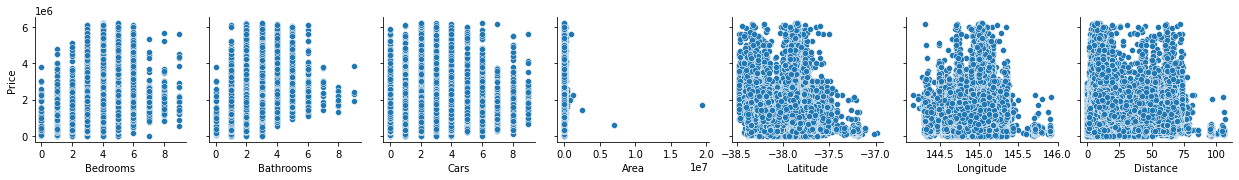

In [7]:
sns.pairplot(data = df, y_vars= ['Price'], x_vars = num_feat)

Using Pandas statistics to look for Outliers

Filter out Outliers using either Z Score Method (normal discribution) or IQR method.

In [8]:
method = 'Zscore'
# Interquartile range (IQR) method should be used for NON normal distribution

def remove_outlier(df_in, col_name):
    q1 = df_in[col_name].quantile(0.25)
    q3 = df_in[col_name].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
    return df_out

if method == 'Zscore':
  df = df[(np.abs(stats.zscore(df['Price'])) < 3)]
  df = df[(np.abs(stats.zscore(df[num_feat])) < 3).all(axis=1)]
  
else:
  remove_outlier(df, num_feat)


Confirm that Outliers have been removed

In [9]:
df.describe()

,Price,Bedrooms,Bathrooms,Cars,Area,Latitude,Longitude,Distance,Suburb_ABBOTSFORD,Suburb_ABERFELDIE,...,Type_Penthouse,Type_Retirement Living,Type_Semi-detached,Type_Studio,Type_Terrace,Type_Townhouse,Type_Villa,Method_Another Method,Method_auction,Method_private treaty
count,5.705800e+04,57058.000000,57058.000000,57058.000000,57058.000000,57058.000000,57058.000000,57058.000000,57058.000000,57058.000000,...,57058.000000,57058.000000,57058.000000,57058.000000,57058.000000,57058.000000,57058.000000,57058.000000,57058.000000,57058.000000
mean,1.254057e+06,3.195731,1.822514,1.803498,656.738669,-37.901479,144.938076,22.939847,0.003277,0.001735,...,0.000018,0.000526,0.000298,0.003032,0.000245,0.128326,0.002366,0.000386,0.396649,0.602965
std,7.335045e+05,1.043526,0.728605,0.964636,5117.921797,0.183445,0.220452,19.061758,0.057155,0.041618,...,0.004186,0.022924,0.017259,0.054981,0.015662,0.334455,0.048585,0.019632,0.489206,0.489288
min,1.000000e+00,0.000000,0.000000,0.000000,0.000000,-38.472143,144.273302,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.550000e+05,3.000000,1.000000,1.000000,0.000000,-37.984948,144.885736,8.233385,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.161250e+06,3.000000,2.000000,2.000000,116.000000,-37.866745,144.995085,16.283557,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,1.730000e+06,4.000000,2.000000,2.000000,607.000000,-37.772816,145.063312,34.687454,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,3.825000e+06,6.000000,4.000000,5.000000,233200.000000,-37.329765,145.496068,77.507458,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


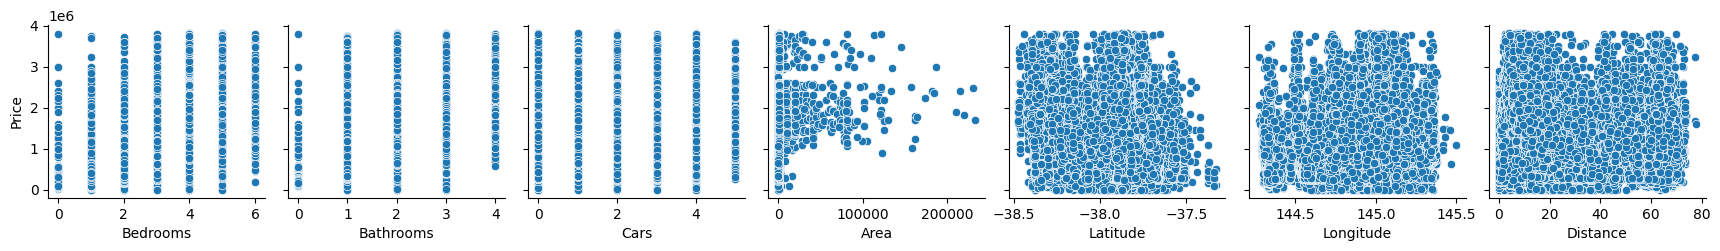

In [10]:
sns.pairplot(data = df,y_vars=['Price'],x_vars=num_feat)

<H4> Plot of Lattitude & longitude showing pricing in each location</H4>
Observe that suburbs closer to the city centre generally are more expensive

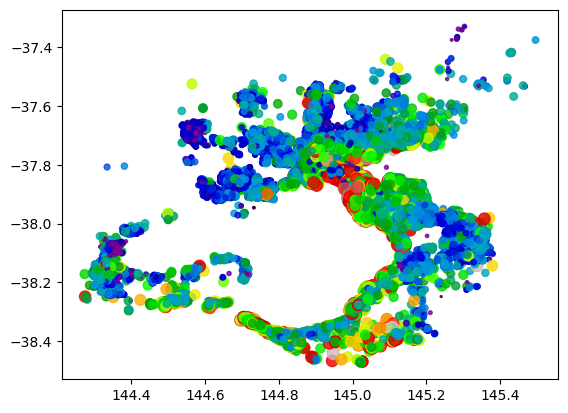

In [11]:
plt.scatter(x = df['Longitude'], y = df['Latitude'],c =df['Price'],alpha=0.8,s=df['Price']/50000,cmap='nipy_spectral' )

Data Splitting into TRAIN,VALIDATION & TEST DF using Scikit Learn function

In [11]:
# Let's split the dataset into train, validation, and test sets as Pandas DF format
train, test = train_test_split(df, test_size=0.2,random_state=42)
train, val = train_test_split(train, test_size=0.2,random_state=42)

print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

36516 train examples
9130 validation examples
11412 test examples


Defining a normalization/scaling function to be used for numerical features

In [12]:
def normalize(df):
    result = df.copy()
    for feature_name in num_feat:
        max_value = df[feature_name].max()
        min_value = df[feature_name].min()
        result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

Normalizing the Training Data,Valuation & test Numerical Features

In [13]:
X_train = normalize(train.drop(['Price'], axis =1))
Y_train = train['Price']

X_test = normalize(test.drop(['Price'], axis =1))
Y_test = test['Price']

X_val = normalize(val.drop(['Price'], axis =1))
Y_val = val['Price']


<h3> Defining & Training a Tensorflow Sequential Regression DNN model.</h3>

In [14]:
# Model create

# `tf.keras.Sequential()` groups a linear stack of layers into a tf.keras.Model.
model = tf.keras.Sequential([
  layers.Dense(256, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(1, activation='linear',  name='Price')
])

# Model compile
model.compile(optimizer='adam',
              loss='mse',
              metrics=['mse'])

# Model Fit
history = model.fit(X_train, Y_train, validation_data = (X_val, Y_val), epochs=20)



2022-07-31 11:00:46.563941: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-31 11:00:46.564958: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-31 11:00:46.565961: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-MM57QPP): /proc/driver/nvidia/version does not exist
2022-07-31 11:00:46.577383: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/20
1142/1142 [==============================] - 8s 6ms/step - loss: 765595811840.0000 - mse: 765595811840.0000 - val_loss: 288453427200.0000 - val_mse: 288453427200.0000
Epoch 2/20
1142/1142 [==============================] - 5s 4ms/step - loss: 216685477888.0000 - mse: 216685477888.0000 - val_loss: 165208834048.0000 - val_mse: 165208834048.0000
Epoch 3/20
1142/1142 [==============================] - 6s 5ms/step - loss: 141920681984.0000 - mse: 141920681984.0000 - val_loss: 132246257664.0000 - val_mse: 132246257664.0000
Epoch 4/20
1142/1142 [==============================] - 6s 5ms/step - loss: 127142461440.0000 - mse: 127142461440.0000 - val_loss: 123563778048.0000 - val_mse: 123563778048.0000
Epoch 5/20
1142/1142 [==============================] - 6s 5ms/step - loss: 121337454592.0000 - mse: 121337454592.0000 - val_loss: 119460904960.0000 - val_mse: 119460904960.0000
Epoch 6/20
1142/1142 [==============================] - 6s 5ms/step - loss: 118323838976.0000 - mse: 118323838

<h4> Evaluating trained model performance using EVALUATION data </h4>

In [15]:
loss, mse = model.evaluate(X_val,Y_val)
print("Mean Squared Error", mse)
print("Root MEAN SQUARE ERROR $",np.sqrt(mse))

286/286 [==============================] - 2s 6ms/step - loss: 113030389760.0000 - mse: 113030389760.0000
Mean Squared Error 113030389760.0
Root MEAN SQUARE ERROR $ 336199.92528256157


<h4> PLOTTING OF LOSS/MSE for TRAINING & EVALUATION DATA  </h4>
Useful to determine underfitting/overfitting as well as optimal number of epcochs for training

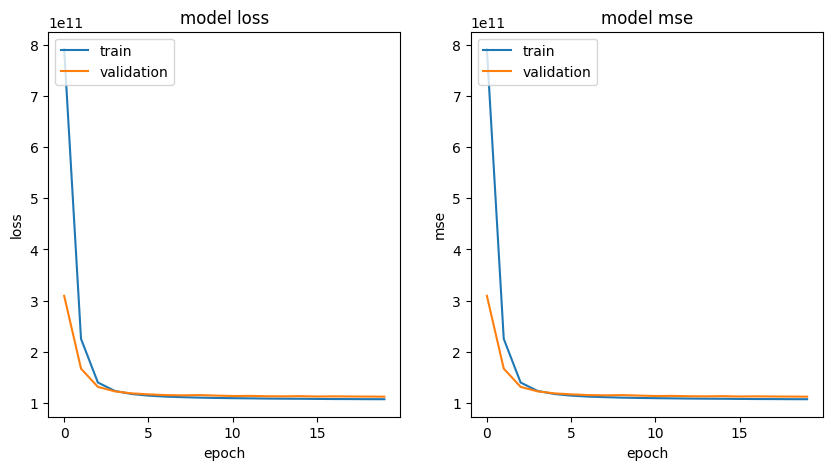

In [17]:
# Use matplotlib to draw the model's loss curves for training and validation
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left');

# Plotting
plot_curves(history, ['loss', 'mse'])

<H3> PREDICTION </H3>
<h4>Using TEST data to make PRICE prediction & compare ACTUAL vs PREDICTED</h4>
 

357/357 [==============================] - 2s 3ms/step
PREDICTION: $1239181.5   ACTUAL: 1455000 DIFFERENCE: $-215.8185
PREDICTION: $1210383.125   ACTUAL: 1400000 DIFFERENCE: $-189.616875
PREDICTION: $1100834.125   ACTUAL: 1320000 DIFFERENCE: $-219.165875
PREDICTION: $2408927.25   ACTUAL: 3630000 DIFFERENCE: $-1221.07275
PREDICTION: $1652000.875   ACTUAL: 1558000 DIFFERENCE: $94.000875
PREDICTION: $846323.9375   ACTUAL: 1340000 DIFFERENCE: $-493.6760625
PREDICTION: $697806.8125   ACTUAL: 660000 DIFFERENCE: $37.8068125
PREDICTION: $1019697.4375   ACTUAL: 850000 DIFFERENCE: $169.6974375
PREDICTION: $1820764.125   ACTUAL: 2010000 DIFFERENCE: $-189.235875
PREDICTION: $1412206.375   ACTUAL: 1410000 DIFFERENCE: $2.206375
PREDICTION: $1237761.375   ACTUAL: 1227000 DIFFERENCE: $10.761375
PREDICTION: $1958571.125   ACTUAL: 3230000 DIFFERENCE: $-1271.428875
PREDICTION: $2309452.25   ACTUAL: 2100000 DIFFERENCE: $209.45225
PREDICTION: $1679089.0   ACTUAL: 1370000 DIFFERENCE: $309.089
PREDICTION: $1

Text(0, 0.5, 'PREDICATED PRICE: $')

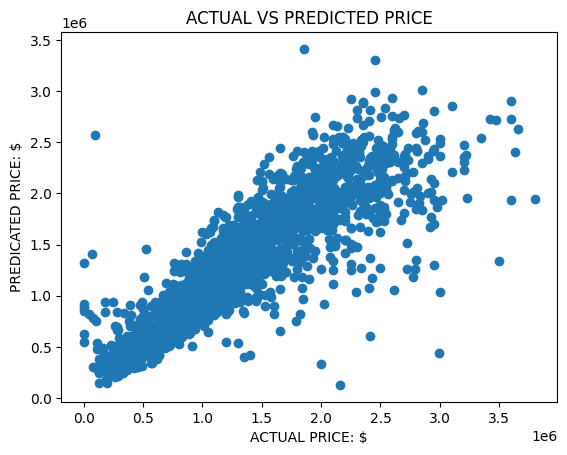

In [16]:
predictions = model.predict(X_test)

#
for i in range(50):
    diff = (predictions[i][0] - test['Price'].iloc[i])/1000
    print('PREDICTION: ${0}'.format(predictions[i][0]) + '   ACTUAL: '+format(test['Price'].iloc[i]) + f' DIFFERENCE: ${diff}')



plt.scatter(Y_test.iloc[0:2000],predictions[0:2000])
plt.title("ACTUAL VS PREDICTED PRICE")
plt.xlabel("ACTUAL PRICE: $")
plt.ylabel("PREDICATED PRICE: $")

<h5> SAVE MODEL </h5>

In [17]:
model.save("saved_models/1")

INFO:tensorflow:Assets written to: saved_models/1/assets


<h4> SERVE MODEL</h4>
<h5> RUN TF SERVING DOCKER CONTAINER </h5>

In [ ]:
#docker run -it -v /home/khaled/AUTOMATION-EXCEL\:/tf_serving -p 8601:8601 --entrypoint /bin/bash tensorflow/serving
#tensorflow_model_server --rest_api_port=8601 --model_name=melb_price --model_base_path=/tf_serving/saved_models/

client = docker.from_env()
container = client.containers.run(image = "tensorflow/serving", ports = {8601:8601},volumes = ['/home/khaled/MLrealestate:/tf_serving'], detach=True)
container.exec_run('/bin/bash')
print(container.exec_run('ls'))
container.exec_run('tensorflow_model_server --rest_api_port=8601 --model_name=real_estate_price_est --model_base_path=/tf_serving/saved_models/',detach = True)

In [ ]:
input = X_test.to_numpy().tolist()[0:5]

data = {"instances": input}
test.head(5)


<h4> API CALL FOR PREDICTION</h4>
<h5>  REST API POST for LOCAL TF SERVING CONTAINER - MODEL NAME: real_estate_est</h5>

In [ ]:
#%%bash
#curl -d '{"instances": [[0.25,0.07553956834532373,0.0,0.25,0.0,0.1937046004842615,0.9103448275862069,0.516068393160683,0.4633053471477789,1.0]]}' \
#-X POST http://localhost:8601/v1/models/melb_price:predict

r = requests.post(url="http://localhost:8601/v1/models/real_estate_price_est:predict", data=json.dumps(data))
print(r.json())

In [ ]:
df= pd.read_csv('data/{city}/{city}_area.csv')
#len(df['Suburb'].unique())
df = df.drop_duplicates(subset=['Suburb','Type','Method'], keep='last')
df.to_csv('data/{city}/{city}_template.csv',index = False)
df.info()
#df.head(20)

In [18]:
%%bash
heroku container:login
heroku container:push web -a tf-serve-model
heroku container:release web -a tf-serve-model
heroku logs -a tf-serve-model --tail

<3>WSL (32429) ERROR: UtilAcceptVsock:247: accept4 failed 110
Error saving credentials: error storing credentials - err: exit status 1, out: ``
 ▸    Login failed with: 1


=== Building web (/home/khaled/MLrealestate/Dockerfile)


#1 [internal] load build definition from Dockerfile
#1 sha256:2e7cf8f82008af76b52f3bc632fc1503544709819529b42d0026b8e6068903ab
#1 transferring dockerfile: 38B done
#1 DONE 0.0s

#2 [internal] load .dockerignore
#2 sha256:34e54ee6560b300a9ae9d7ff20d3fb8f37131f923a260b939c343a1c72eddcdb
#2 transferring context: 2B done
#2 DONE 0.0s

#3 [internal] load metadata for docker.io/tensorflow/serving:latest
#3 sha256:aabbaaaba4a098248e3a3b94a5f8adf60cb615eb5f958ac0e965e44e0487385a
#3 DONE 0.0s

#5 [internal] load build context
#5 sha256:8433ca72d78ee49816cf968095c9f5660493f0ae4684784c02110b688c08bebe
#5 transferring context: 2.04MB 0.0s done
#5 DONE 0.0s

#4 [1/4] FROM docker.io/tensorflow/serving
#4 sha256:b6d7cdb57d0ca0f670a7b0c7844be7c5df5d02f320b4c243c4945f0e96f43f81
#4 CACHED

#6 [2/4] COPY /saved_models /models/model
#6 sha256:8597cae35754e0bddbeda708ee9d7de705d919d1f77bdf4e8c1d2d1a182bd596
#6 DONE 0.1s

#7 [3/4] COPY tf_serving_entrypoint.sh /usr/bin/tf_serving_entrypoint.sh
#7 sha256:2d6

=== Pushing web (/home/khaled/MLrealestate/Dockerfile)
Using default tag: latest
Error while terminating subprocess (pid=32362): 
